In [1]:
from UTILS_TF2 import model_parameters, confusion, predict_full, xcorr_target, getROCdata, catalog_predictions
import numpy as np
import pandas as pd
import os
import matplotlib.pylab as plt
%matplotlib inline
from scipy import signal as sig
import urllib.request
import pandas as pd
import re
import os
import errno
import obspy
from obspy.core import *
from obspy.signal.trigger import classic_sta_lta, pk_baer, ar_pick, trigger_onset
import numpy as np
from pathlib import Path
import time
import sys
import datetime
from philipperemy_keras_tcn_TF2 import dilated_tcn
import matplotlib.pyplot as plt
import matplotlib
from phasepicker import fbpicker, ktpicker, aicdpicker
import string

/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/site-packages/obspy/signal/headers.py:93: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ], align=True)


In [2]:
def plotSNRPERF(cat, SNR_bins, det_columns=None, ax=None, sz=[None, None, None, None], title=None ):
    ax = ax or plt.gca()
    ax.cla()
    
    det_columns = det_columns or [c for c in cat.columns if c[:3] == 'DET']
    detperSNR = np.zeros((len(SNR_bins)-1,len(det_columns)))

    for j, det_column in enumerate(det_columns):
        for i in range(len(detperSNR)):
            low = SNR_bins[i]
            hi = SNR_bins[i+1]

            SNRbin_cat = cat.loc[(cat.SNR > low) & (cat.SNR < hi)]
            detperSNR[i,j] = np.mean(SNRbin_cat[det_column])

        if j == 0:
            linestyle='-'
            linewidth='3'
        else:
            linestyle='--'

        ax.plot(SNR_bins[:-1], detperSNR[:,j], linestyle=linestyle, label=det_column.split('_')[1] )
    
    ax.tick_params(labelsize=sz[3])
    ax.set_xlabel('Seismogram SNR (dB)', fontsize=sz[2])
    ax.set_ylabel('Detection Rate (%)', fontsize=sz[2])
    ax.set_yticks(np.arange(0, 1.1, step=0.1))
    ax.set_xticks(SNR_bins[:-1])
    if title is not None:
        ax.set_title(title, fontsize=sz[0])
    ax.grid(color='grey', linestyle='--', linewidth=.5)
    ax.legend(loc='lower right', fontsize=sz[3], fancybox=True, framealpha=0.5)

In [3]:
import numpy as np
np.hstack([np.ones(5), np.zeros(3)])

array([1., 1., 1., 1., 1., 0., 0., 0.])

## Plot Previous Results

In [4]:
# testsets = ['PDAR_2015_1_2015_2']
# models = ['best_model_360sec_200buf_0.02fmin_300aw_0.02dec_10amp_max--MKAR_20f_16k_12s_1x2x4x8d.h5']

In [5]:
testsets = ['TXAR','PDAR', 'ILAR',  'BURAR', 'ABKAR', 'MKAR', 'ASAR']
models = [
    'best_model_360sec_200buf_0.02fmin_300aw_0.02dec_10amp_max--PDAR+MKAR+ABKAR+ASAR+BURAR+ILAR_20f_16k_12s_1x2x4x8d.h5',
    'best_model_360sec_200buf_0.02fmin_300aw_0.02dec_10amp_max--ASAR+MKAR+ABKAR+TXAR+BURAR+ILAR_20f_16k_12s_1x2x4x8d.h5',
    'best_model_360sec_200buf_0.02fmin_300aw_0.02dec_10amp_max--PDAR+MKAR+ABKAR+TXAR+BURAR+ASAR_20f_16k_12s_1x2x4x8d.h5',
    'best_model_360sec_200buf_0.02fmin_300aw_0.02dec_10amp_max--PDAR+MKAR+ABKAR+TXAR+ASAR+ILAR_20f_16k_12s_1x2x4x8d.h5',
    'best_model_360sec_200buf_0.02fmin_300aw_0.02dec_10amp_max--MKAR+PDAR_20f_16k_12s_1x2x4x8d.h5',
    'best_model_360sec_200buf_0.02fmin_300aw_0.02dec_10amp_max--PDAR+ASAR+ABKAR+TXAR+BURAR+ILAR_20f_16k_12s_1x2x4x8d.h5',
    'best_model_360sec_200buf_0.02fmin_300aw_0.02dec_10amp_max--PDAR+MKAR+ABKAR+TXAR+BURAR+ILAR_20f_16k_12s_1x2x4x8d.h5']

0
1
2
3
4
5
6
\begin{tabular}{lllllllllll}
\toprule
{} &      RF &  DP\_TP & DP\_TPR & DP\_FPR &  FB\_TP & FB\_TPR & FB\_FPR &  KT\_TP & KT\_TPR & KT\_FPR \\
\midrule
TXAR  &   16451 &   9265 &    57\% &  0.001 &   2933 &    18\% &  0.002 &   6040 &    37\% &  0.002 \\
PDAR  &   12980 &   6966 &    54\% &  0.001 &   2118 &    17\% &  0.003 &   3691 &    29\% &  0.001 \\
ILAR  &   20769 &  10269 &    50\% &  0.002 &   3677 &    18\% &  0.005 &   6371 &    31\% &  0.002 \\
BURAR &    4645 &   3685 &    80\% &  0.001 &   1565 &    34\% &  0.004 &   2679 &    58\% &  0.001 \\
ABKAR &    8072 &   5940 &    74\% &  0.002 &   4015 &    50\% &  0.004 &   5951 &    74\% &  0.002 \\
MKAR  &   40583 &  24473 &    61\% &  0.001 &  14118 &    35\% &  0.002 &  20031 &    50\% &  0.001 \\
ASAR  &   37595 &  18204 &    49\% &  0.002 &   9146 &    25\% &  0.005 &  13752 &    37\% &  0.003 \\
TOTAL &  141095 &  78802 &    56\% &  0.001 &  37572 &    27\% &  0.003 &  58515 &    42\% &  0.002 \\
\bottomru

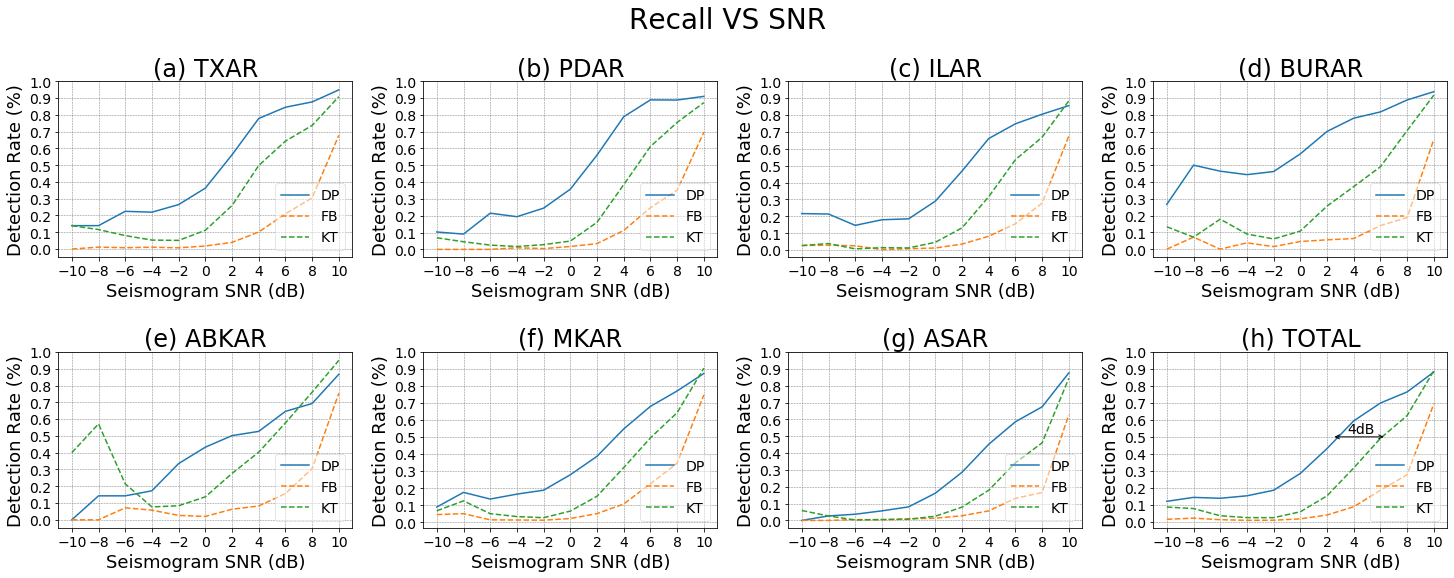

In [8]:

fig, axes = plt.subplots(2,4, figsize=(20,8))
fig.suptitle('Recall VS SNR', fontsize=28)
fs=[24, 20, 18, 14]
tpr_df = pd.DataFrame()
mae_df = pd.DataFrame()
cmp_df = pd.DataFrame()
tot_cat = []

bins = [-21, -14, -7, 0, 7, 14, 21, 28, 100]
bins = [-18, -15, -12, -9, -6, -3, 0, 3, 6, 9, 12, 15, 18, 100]
bins = [-15, -10, -5, 0, 5, 10, 15, 100]
bins = [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 100]
bins = [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 100]
#bins = [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 100]
#bins = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100]

for i in range(len(models)):
    print(i)
    ax=axes[(int(i/4),i%4)]
    testset_name = testsets[i]
    model_name = models[i]
    RESULTS_dir = f'results/{testset_name}_{model_name[:-4]}'
    title = f'({string.ascii_lowercase[i]}) {testset_name}'

    eval_cat = pd.read_csv(os.path.join(RESULTS_dir, 'EVAL_cat'), index_col=0)
    #if i ==4:
    #    eval_cat = eval_cat.loc[(eval_cat.SNR > -4) | ((eval_cat.SNR < -4) & (eval_cat.DET_KT_5 == 0))]
    eval_stats = pd.read_csv(os.path.join(RESULTS_dir, 'EVAL_stats'), index_col=0)
    old_col = [c for c in eval_cat.columns if c[:3] == 'DET']
    new_col = [f'DET_{c.split("_")[1]}' for c in old_col]

    tot_cat.append(eval_cat[ [c for c in eval_cat.columns if c[:3] == 'DET'] + ['SNR'] ].rename(index=str, columns=dict(zip(old_col,new_col))))


    plotSNRPERF(eval_cat, bins, sz=fs, ax=ax, title=title)

    
    tpr_columns = [c[4:] for c in eval_cat.columns if c[:3] == 'DET']
    #print(eval_stats[eval_stats.PICKER.isin(det_columns)][['PICKER', 'TPR', 'FPR', 'FP', 'RUNTIME']])
    tpr_df.loc[testset_name, 'RF'] = f'{len(eval_cat)}'
    for col in tpr_columns:
        tpr_df.loc[testset_name, f'{col.split("_")[0]}_TP'] = f'{eval_stats.loc[eval_stats.PICKER == col].TP.values[0]}'
        tpr_df.loc[testset_name, f'{col.split("_")[0]}_FP'] = f'{eval_stats.loc[eval_stats.PICKER == col].FP.values[0]}'
        tpr_df.loc[testset_name, f'{col.split("_")[0]}_TPR'] = f'{np.int(np.ceil(eval_stats.loc[eval_stats.PICKER == col].TPR.values[0]*100))}%'
        tpr_df.loc[testset_name, f'{col.split("_")[0]}_FPR'] = f'{np.round(eval_stats.loc[eval_stats.PICKER == col].FPR.values[0],3)}'
        
        mae_df.loc[testset_name, f'{col.split("_")[0]}_MAE'] = f'{np.round(eval_stats.loc[eval_stats.PICKER == col].MAE.values[0],3)}'
        cmp_df.loc[testset_name, f'{col.split("_")[0]}_CMP'] = f'{np.int(eval_stats.loc[eval_stats.PICKER == col].RUNTIME.values[0])}'
tot_cat = pd.concat(tot_cat)
ax=axes[-1, -1]
plotSNRPERF(tot_cat, bins, sz=fs, ax=ax, title='(h) TOTAL')
ax.annotate('4dB', xy=(3.5, .52), xytext=(3.5, .52), fontsize=14)
ax.annotate('', xy=(2.4, .5), xytext=(6.4, .5), arrowprops=dict(arrowstyle="<->", facecolor='black'))

fig.tight_layout(pad=0, w_pad=2, h_pad=4)
fig.subplots_adjust(top=.85)

for col in tpr_df.columns:
    
    if (col[-2:] == 'RF') | (col[-2:] == 'TP') | (col[-2:] == 'FP'):
        tot = np.sum(tpr_df[col].fillna(0).astype(int).values)

    if col[-3:] == 'TPR':
        tot = f"{np.int(np.ceil(tpr_df.loc['TOTAL', f'{col[:2]}_TP'] / tpr_df.loc['TOTAL', 'RF']*100))}%"

    if col[-3:] == 'FPR':
        tot = np.round(np.mean(tpr_df[col].fillna(0).astype(float).values),3)

        
    tpr_df.loc['TOTAL', col] = tot

for col in mae_df.columns:
    mae_df.loc['TOTAL', col] = f"{np.round(np.sum(mae_df[col].fillna(0).astype(float).values)/7,3)}"

for col in cmp_df.columns:
    cmp_df.loc['TOTAL', col] = f"{np.int(np.sum(cmp_df[col].fillna(0).astype(float).values)/7)}"
    
plt_file = os.path.join('results', f'SNRcurves.png')
fig.savefig(plt_file, dpi=600, transparent=False)
tpr_df.to_csv(os.path.join('results', f'alg_TPR_by_sta'))
mae_df.to_csv(os.path.join('results', f'alg_MAE_by_sta'))
cmp_df.to_csv(os.path.join('results', f'alg_CMP_by_sta'))

print(tpr_df[['RF','DP_TP','DP_TPR','DP_FPR','FB_TP','FB_TPR','FB_FPR','KT_TP','KT_TPR','KT_FPR']].to_latex())
print(mae_df.to_latex())
print(cmp_df.to_latex())